LABandHW5

In [ ]:
import cv2
import matplotlib.pyplot as plt
import imutils
import numpy as np
import tqdm
from collections import Counter
from itertools import chain
import copy

In [23]:
img = cv2.imread("image.jpg")
img = imutils.resize(img, width=1024)
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

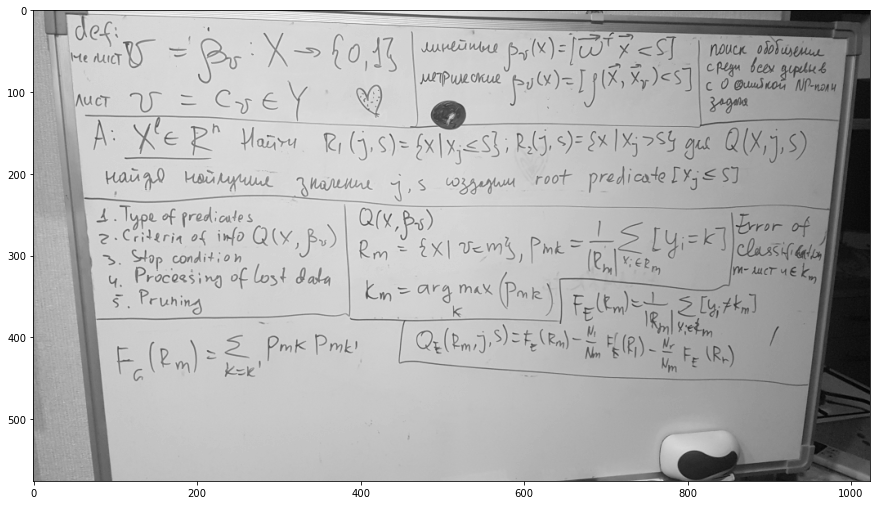

In [24]:
plt.figure(figsize=(15,15))
plt.imshow(img, cmap="gray")

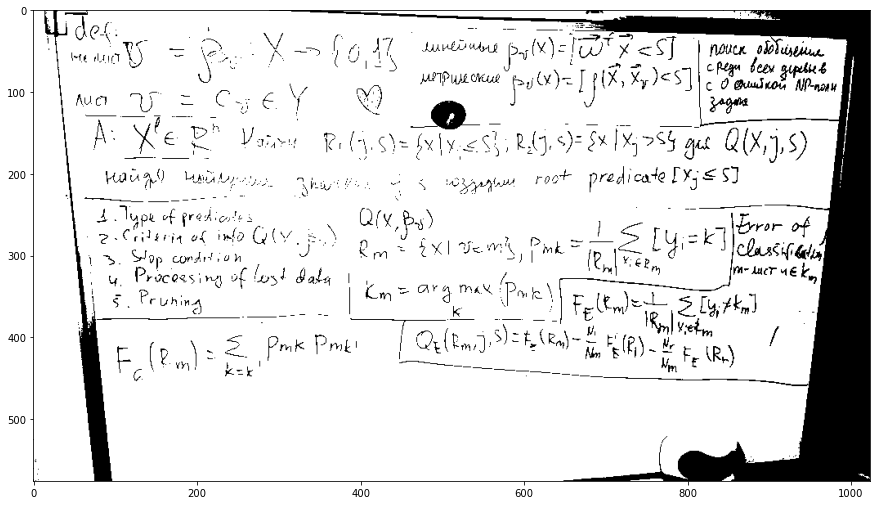

In [25]:
# print(img[:10])
bin_img = (img/255>0.5).astype(np.int)
plt.figure(figsize=(15,15))
plt.imshow(bin_img,cmap="gray")

In [26]:
height = bin_img.shape[0]
width = bin_img.shape[1]
c2ind = lambda y,x: y*width+x
ind2c = lambda ind: (ind//width,ind%width)

In [28]:
c2ind(100,111)

102511

In [29]:
ind2c(102511)

(100, 111)

In [30]:
from disjoint_set import DisjointSet
ds = DisjointSet()

In [31]:
print(ds)

DisjointSet()


In [32]:
res = np.where(bin_img==0)

In [33]:
zero_pairs=set(zip(res[0],res[1]))

In [34]:
len(zero_pairs)

73881

In [35]:
zero_inds = set([c2ind(y,x) for y,x in zero_pairs])

In [36]:
class my_ds():
    def __init__(self):
        self.A = {}
        self.rank = {}  
        
    def Find(self, i):
        while i!= self.A[i]:
            i = self.A[i]
        return i
    
    def MakeSet(self, i):        
        self.A[i] = i  
        self.rank[i] = 0

    def union(self,i,j):
        i_id = self.Find(j)
        j_id = self.Find(i)
        if (i_id == j_id):
            return 
        if self.rank[i_id] > self.rank[j_id]:
            for bbb in self.A.keys():
                if self.A[bbb] == j_id:
                    self.A[bbb] = i_id
            self.A[j_id] = i_id       
        else:
            for bbb in self.A.keys():
                if self.A[bbb] == i_id:
                    self.A[bbb] = j_id
            self.A[i_id] = j_id
            if self.rank[i_id] == self.rank[j_id]:
                self.rank[j_id] = self.rank[j_id] + 1
        #return self.A, self.rank
    
    def iterSets(self):
        sets = set(self.A.values())
        res = []
        for s in tqdm.tqdm(sets):
            seed = set()
            #seed.add(s)
            for j in self.A.keys():
                if (self.A[j] == s):
                    seed.add(j)
            res.append(seed)
        return res, self.A

In [37]:
ds = my_ds()

In [40]:
for ind in zero_inds:
    ds.MakeSet(ind)

In [41]:
for y,x in tqdm.tqdm(zero_pairs):
    for dy in range(-1,2):
        for dx in range(-1,2):
            if (dx!=0 or dy!=0) and (y+dy,x+dx) in zero_pairs:
                ds.union(c2ind(y,x),c2ind(y+dy,x+dx)) 


100%|██████████| 73881/73881 [10:40<00:00, 115.35it/s] 


In [42]:
z = ds.iterSets()

100%|██████████| 1022/1022 [00:08<00:00, 116.30it/s]


In [46]:
from matplotlib import cm
fltr_img = np.ones(shape=(height,width,4))
sets_size = len(list(z[0]))
mycm = cm.get_cmap("seismic",sets_size)

print(sets_size)
for num_set,els in enumerate(z[0]):
    if len(els)<270:
        for ind in els:
            fltr_img[(ind2c(ind))] = mycm(num_set)  
    

1022


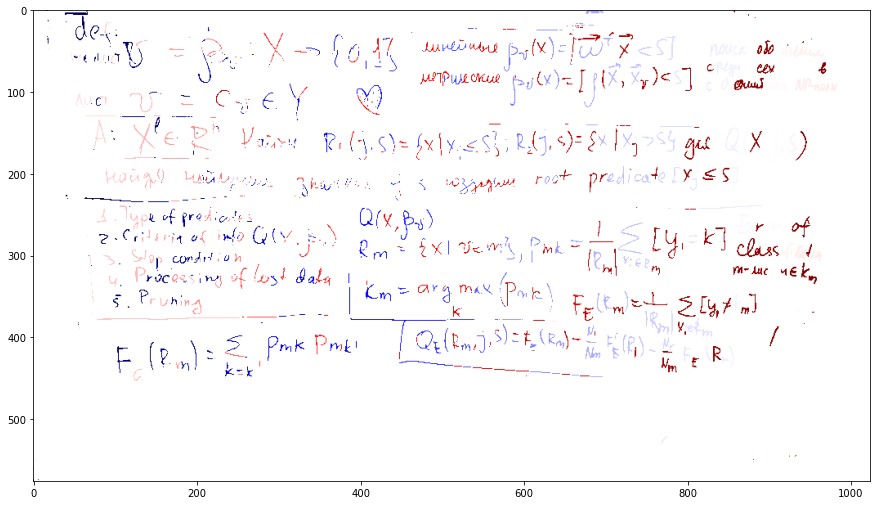

In [47]:
plt.figure(figsize=(15,15))
plt.imshow(fltr_img)

# Homework
* Написать функцию расчета периметра для связанных множеств в ds.itersets()
* Написать фунцию фильтрации на основе периметра
* Построить словарь соотношения площади к периметру(или наоборот) и визуализировать какие объекты попали в этом словарь


a*a/4*a = a/4

pi*r^2/2*pi*r = r/2

h*a/2 / (a+b+c) = ?

[0, C] => [0,1]

[0,0.3]; => viz
[0.3,0.6]; => viz
[0.6,1]; => viz


In [49]:
# subtract pixels from area
def perimetr(dots):
    P = len(dots)
    figure = [ind2c(d) for d in dots]
    for x in figure: 
        count = 0
        for dx in range(-1,2):
            for dy in range(-1,2):
                #если все точки вокруг фигуры и сама точка содержатся в фигуре, то вычитаем ее из площади
                if (x[0] + dx, x[1] + dy) in figure:
                    count = count + 1
        #всего вокруг точек 8 + 1 (сама точка)
        if (count >= 9):
            P = P - 1
    return P

In [51]:
# perimeter filtering
from matplotlib import cm
fltr_img = np.ones(shape=(height,width,4))
sets_size = len(list(z[0]))
mycm = cm.get_cmap("seismic",sets_size)

print(sets_size)
for num_set,els in enumerate(z[0]):
    P = perimetr(els)
    if P<150:
        for ind in els:
            fltr_img[(ind2c(ind))] = mycm(num_set)

1022


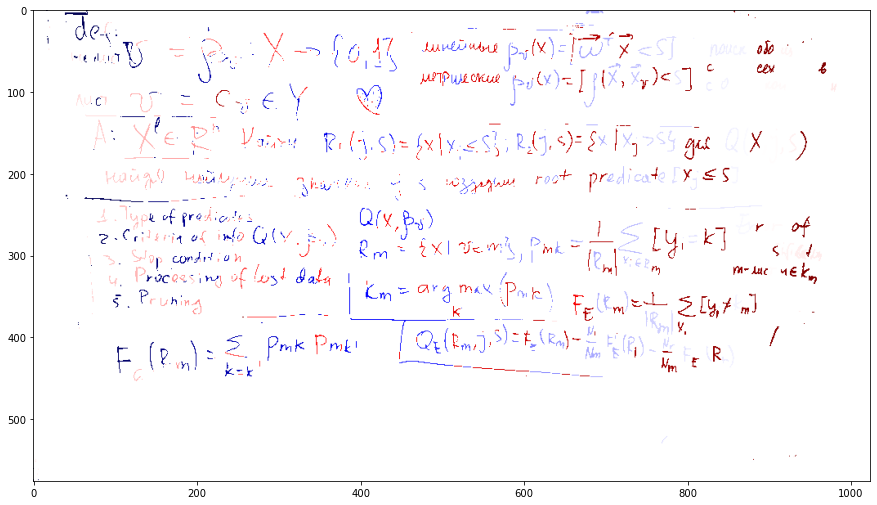

In [52]:
plt.figure(figsize=(15,15))
plt.imshow(fltr_img)

In [53]:
fltr_img_small = np.ones(shape=(height,width,4))
fltr_img_mid = np.ones(shape=(height,width,4))
fltr_img_big = np.ones(shape=(height,width,4))
sets_size = len(list(z[0]))
mycm = cm.get_cmap("seismic",sets_size)
for num_set,els in enumerate(z[0]):
    if (num_set%100 == 0):
        print(num_set,'------------')
    S = len(els)
    P = perimetr(els)
    if (P/S) < 0.3:
        for ind in els:
            fltr_img_small[(ind2c(ind))] = mycm(num_set) 
    if (P/S >= 0.3) and (P/S <= 0.6):
        for ind in els:
            fltr_img_mid[(ind2c(ind))] = mycm(num_set)  
    if P/S > 0.6:
        for ind in els:
            fltr_img_big[(ind2c(ind))] = mycm(num_set)

0 ------------
100 ------------
200 ------------
300 ------------
400 ------------
500 ------------
600 ------------
700 ------------
800 ------------
900 ------------
1000 ------------


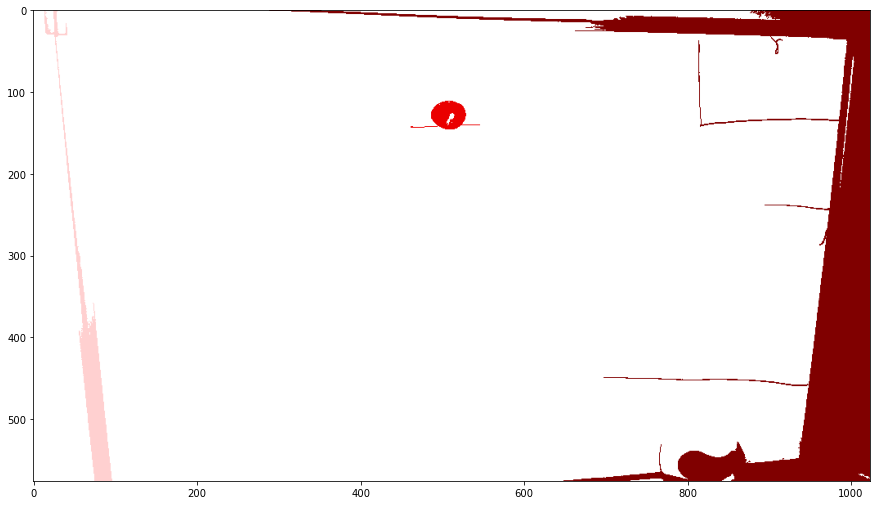

In [54]:
plt.figure(figsize=(15,15))
plt.imshow(fltr_img_small)

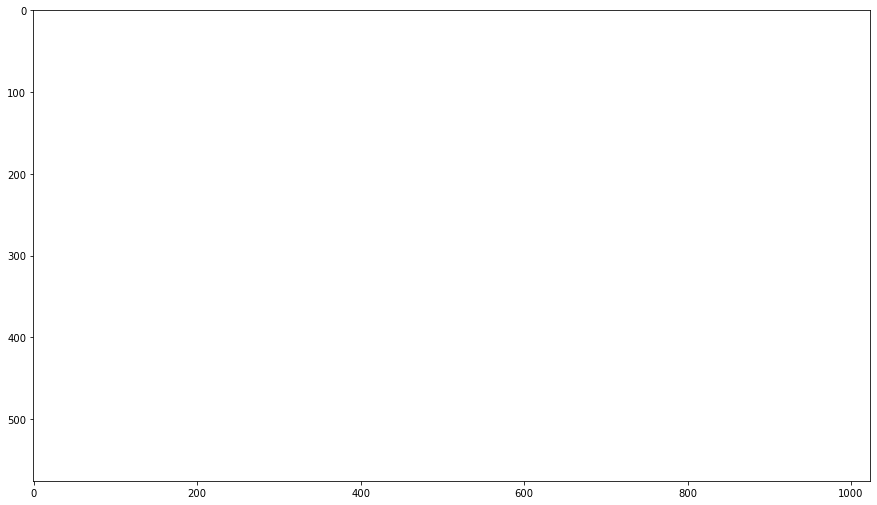

In [55]:
plt.figure(figsize=(15,15))
plt.imshow(fltr_img_mid)

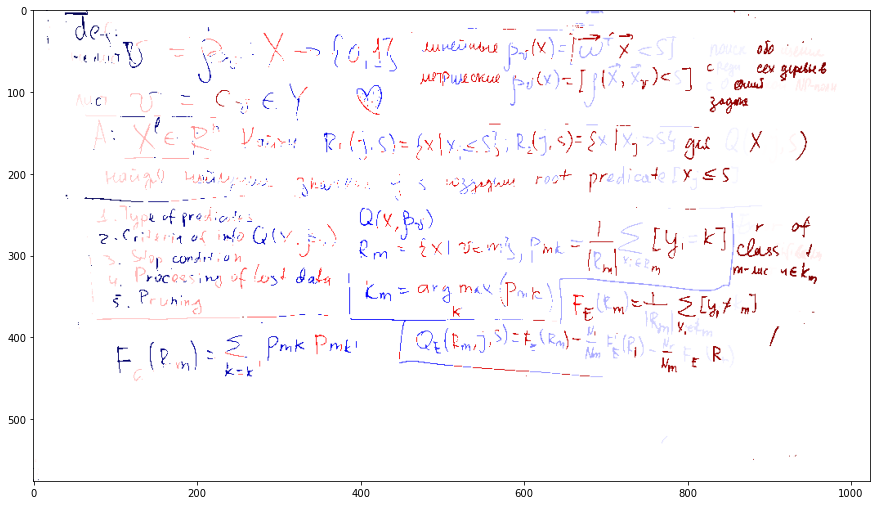

In [56]:
plt.figure(figsize=(15,15))
plt.imshow(fltr_img_big)